In [1]:
from astropy.modeling import models, Fittable1DModel, Parameter
from astropy.modeling import fitting
import astropy.units as u
import astropy.constants as const

from spectacle.core.spectrum import Spectrum1D
from spectacle.models.custom import Masker

import numpy as np

import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['text.latex.preamble'] = [r"\usepackage{siunitx}"]

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import seaborn as sns
sns.set_style("whitegrid", {'grid.color': '.95', 'font.family': 'sans-serif', 'font.sans-serif': 'Arial'})
# sns.despine(offset=10, trim=True)

In [2]:
%matplotlib notebook
plt.rcParams["figure.figsize"] = [6, 8]
# plt.rcParams["figure.dpi"] = 80

## Control Spectrum

This spectrum acts as the standard to which the dynamic spectrum will be compared in the correlation metrics.

In [3]:
wavelength = np.linspace(1000, 2000, 1001) * u.Angstrom
velocity = np.linspace(-800, 800, 401) * u.Unit('km/s')

In [4]:
# Define the parameter ranges
v_doppler_range = np.linspace(1e6, 1e7, 3) * u.Unit('cm/s')
column_density_range = np.linspace(1e13, 1e14, 3) * u.Unit('1/cm2')
delta_lambda_range = np.linspace(0, 2, 100) * u.Angstrom
delta_v_range = np.linspace(0, 300, 100) * u.Unit('km/s')

def generate(corr_func):
    # Define the control spectrum. It does not change.
    line1 = dict(lambda_0=1.21567010E+03 * u.Angstrom,
                 gamma=6.2650000e+08, 
                 f_value=4.1640E-01,
                 v_doppler=v_doppler_range[1],
                 column_density=column_density_range[1])

    spectrum1 = Spectrum1D(center=line1['lambda_0']).add_line(**line1)
    
    x1_f, y1_f = Masker(continuum=np.ones(velocity.shape))(velocity, spectrum1.flux(velocity))
    x1_t, y1_t = Masker()(velocity, spectrum1.tau(velocity))
    x1_d, y1_d = Masker()(velocity, spectrum1.flux_decrement(velocity))
    
    pline1 = [{'x': x1_t, 'y': y1_t}]
    pline2 = []
    
    def perform_variations(v_dop, col_dens):
        corr, corr_tau, corr_dec = [], [], []

        for dv in delta_v_range:
            line2 = dict(lambda_0=1.21567010E+03 * u.Angstrom,
                         gamma=6.2650000e+08, 
                         f_value=4.1640E-01,
                         v_doppler=v_dop,
                         column_density=col_dens,
                         delta_v=dv)
            
            spectrum2 = Spectrum1D(center=line2['lambda_0']).add_line(**line2)
            
            x2_f, y2_f = Masker(continuum=np.ones(velocity.shape))(velocity, spectrum2.flux(velocity))

            corr.append(corr_func(x1_f, x2_f, y1_f, y2_f))
            
            x2_t, y2_t = Masker()(velocity, spectrum2.tau(velocity))

            corr_tau.append(corr_func(x1_t, x2_t, y1_t, y2_t))
            
            x2_d, y2_d = Masker()(velocity, spectrum2.flux_decrement(velocity))

            corr_dec.append(corr_func(x1_d, x2_d, y1_d, y2_d))
            
            pline2.append({'x': x2_t, 'y': y2_t})
        
        return corr, corr_tau, corr_dec
    
    corr_mat_tau = np.zeros((v_doppler_range.size, column_density_range.size, delta_v_range.size))
    corr_mat_flux = np.zeros((v_doppler_range.size, column_density_range.size, delta_v_range.size))
    corr_mat_flux_dec = np.zeros((v_doppler_range.size, column_density_range.size, delta_v_range.size))
        
    for i, v_dop in enumerate(v_doppler_range):
        for j, col_dens in enumerate(column_density_range):
            corr_flux, corr_tau, corr_dec = perform_variations(v_dop, col_dens)
            
            corr_mat_tau[i][j] = corr_tau
            corr_mat_flux[i][j] = corr_flux
            corr_mat_flux_dec[i][j] = corr_dec
    
#     for i, v_dop in enumerate(v_doppler_range):
#     corr_flux, corr_tau, corr_dec = perform_variations(v_doppler_range[1], column_density_range[2])
    
    return {
        'tau': {
            'line1': pline1,
            'line2': pline2,
            'corr': corr_mat_tau
        },
        'flux': {
            'line1': (x1_t, y1_t),
            'corr': corr_mat_flux
        },
        'flux_dec': {
            'line1': (x1_d, y1_d),
            'corr': corr_mat_flux_dec
        },
    }

In [5]:
def plot_corr(res):
    corr_flux = res['flux']['corr']
    corr_tau = res['tau']['corr']
    corr_flux_dec = res['flux_dec']['corr']
    
    f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)

    f.subplots_adjust(hspace=0)
    
    ax1.set_ylabel("Correlation in Tau")
    
    ax2.set_ylabel("Correlation in Flux")
    
    ax3.set_ylabel("Correlation in Flux Decrement")
    ax3.set_xlabel("$\Delta v$ [$\si{km.s^{-1}}$]")
    
    colors = sns.color_palette()
    line_styles = ['--', '-.', ':']

    # Variations in vdop
    for i in range(len(v_doppler_range)):
        for j in range(len(column_density_range)):
            ax1.plot(delta_v_range, corr_tau[i, j],
                     color=colors[i], 
                     linestyle=line_styles[j]
                    )
            ax2.plot(delta_v_range, corr_flux[i, j],
                     color=colors[i], 
                     linestyle=line_styles[j]
                    )
            ax3.plot(delta_v_range, corr_flux_dec[i, j],
                     color=colors[i], 
                     linestyle=line_styles[j]
                    )

    #Create legend from custom artist/label lists
    ax1.legend([plt.Line2D((0,1),(0,0), color='k', linestyle='--'),
                plt.Line2D((0,1),(0,0), color='k', linestyle='-.'),
                plt.Line2D((0,1),(0,0), color='k', linestyle=':'),
                plt.Line2D((0,1),(0,0), linestyle='', marker='o', color=colors[0]),
                plt.Line2D((0,1),(0,0), linestyle='', marker='o', color=colors[1]),
                plt.Line2D((0,1),(0,0), linestyle='', marker='o', color=colors[2])],
              ["$\\num{{ {0.value:0.02e} }}$ {0.unit:latex}".format(x) for x in v_doppler_range] + 
              ["$\\num{{ {0.value:0.02e} }}$ {0.unit:latex}".format(x) for x in column_density_range],
              ncol=2)

            
def plot_shift(res):
    line1 = res['tau']['line1']
    line2 = res['tau']['line2']
    
    f, ax1 = plt.subplots()
    f.set_size_inches(8, 6)
    
    ax1.set_ylabel('Tau')
    ax1.set_xlabel("$\Delta v$ [km/s]")
    
    for i, d in enumerate(line2[::11]):
        if i == 0:
            ax1.plot(d['x'], d['y'], color=sns.color_palette()[1], alpha=0.5, label="Comparative Profile")
        else:
            ax1.plot(d['x'], d['y'], color=sns.color_palette()[1], alpha=0.5)
    
    for d in line1:
        ax1.plot(d['x'], d['y'], label="Fiducial Profile")
        
    ax1.legend(loc=0)


<IPython.core.display.Javascript object>


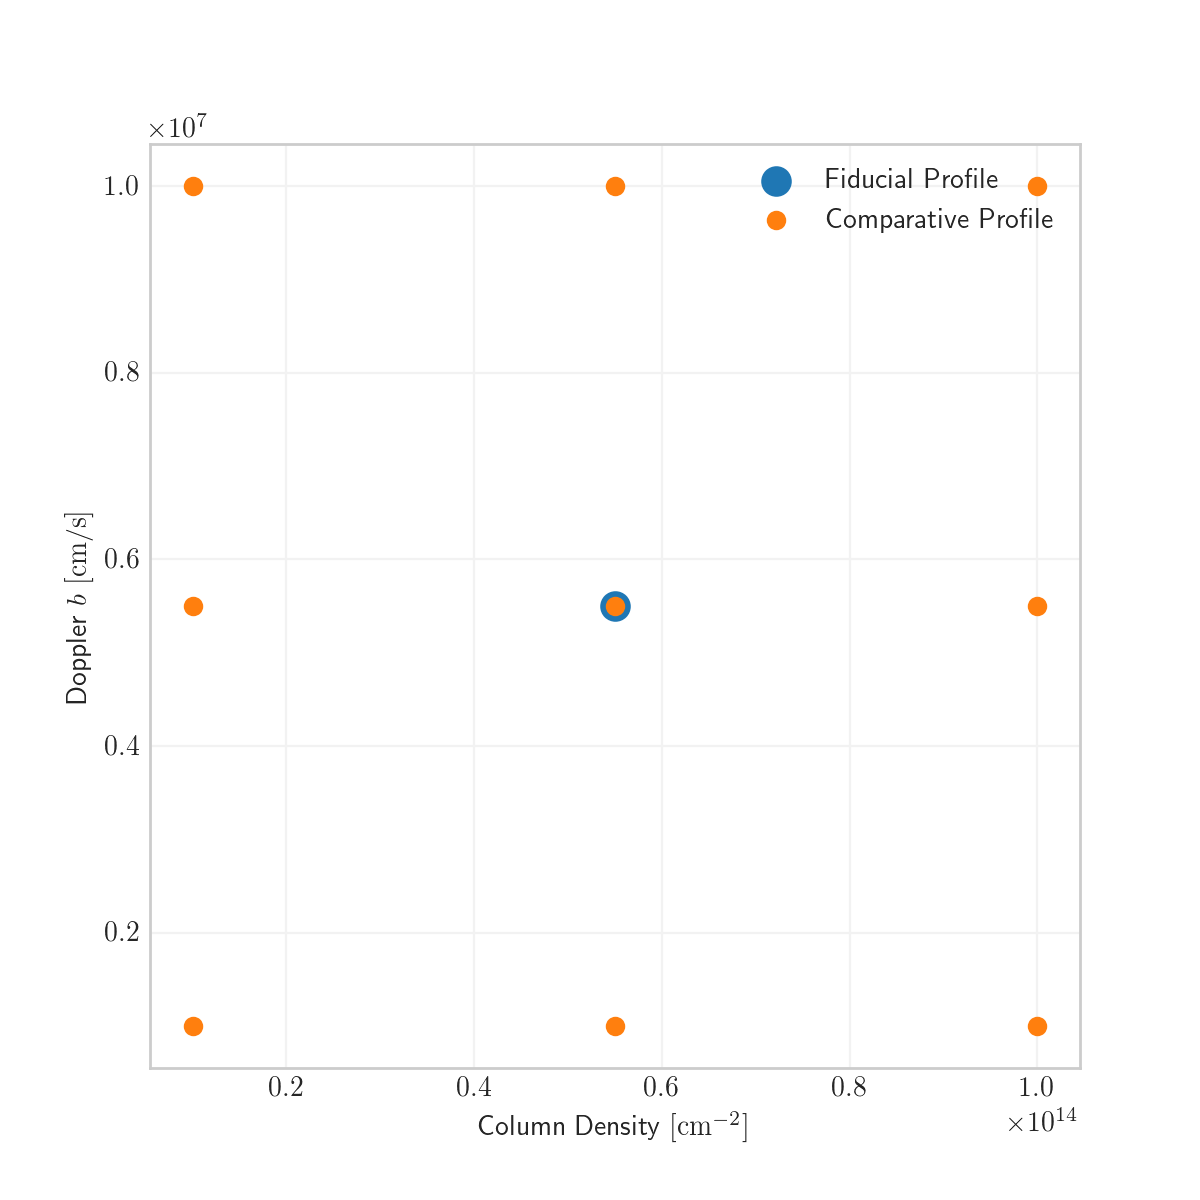

In [6]:
# res = generate(lambda x1, x2, y1, y2: 0)
# plot_shift(res)

import itertools

f, ax1 = plt.subplots()
f.set_size_inches(6, 6)

ax1.set_xlabel("Column Density $[\si{cm^{-2}}]$")
ax1.set_ylabel("Doppler $b$ $[\si{cm/s}]$")

x, y = list(zip(*list(itertools.product(column_density_range, v_doppler_range))))

ax1.scatter([column_density_range[1].value], [v_doppler_range[1].value], s=100, label="Fiducial Profile")
ax1.scatter([i.value for i in x], [i.value for i in y], label="Comparative Profile")

ax1.legend(loc=0)
# ax1.set_yscale('log')
# ax1.set_xscale('log')


/Users/nearl/anaconda3/envs/spectacle_env/lib/python3.6/site-packages/ipykernel_launcher.py:61: UserWarning: Warning: converting a masked element to nan.
/Users/nearl/anaconda3/envs/spectacle_env/lib/python3.6/site-packages/ipykernel_launcher.py:62: UserWarning: Warning: converting a masked element to nan.
/Users/nearl/anaconda3/envs/spectacle_env/lib/python3.6/site-packages/ipykernel_launcher.py:63: UserWarning: Warning: converting a masked element to nan.


<IPython.core.display.Javascript object>


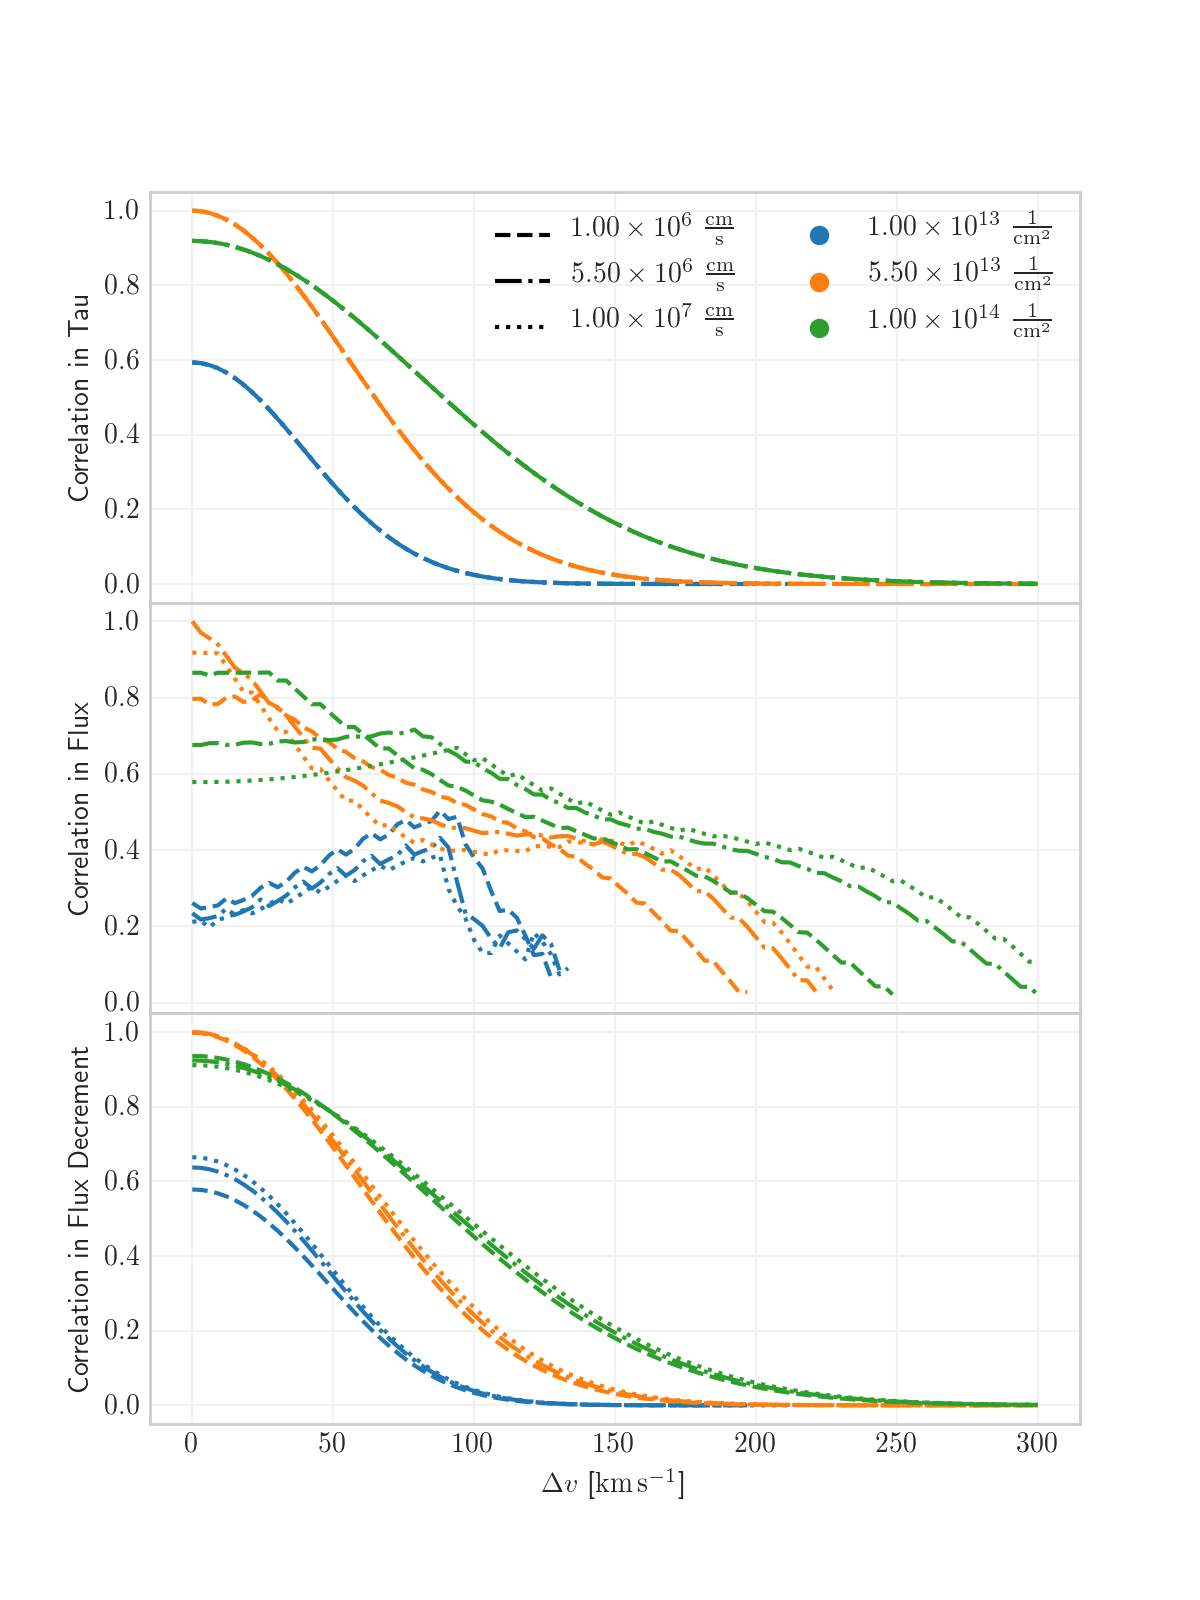

In [7]:
from spectacle.analysis.metrics import Epsilon
res = generate(lambda x1, x2, y1, y2: Epsilon()(y1, y2))
plot_corr(res)

<IPython.core.display.Javascript object>


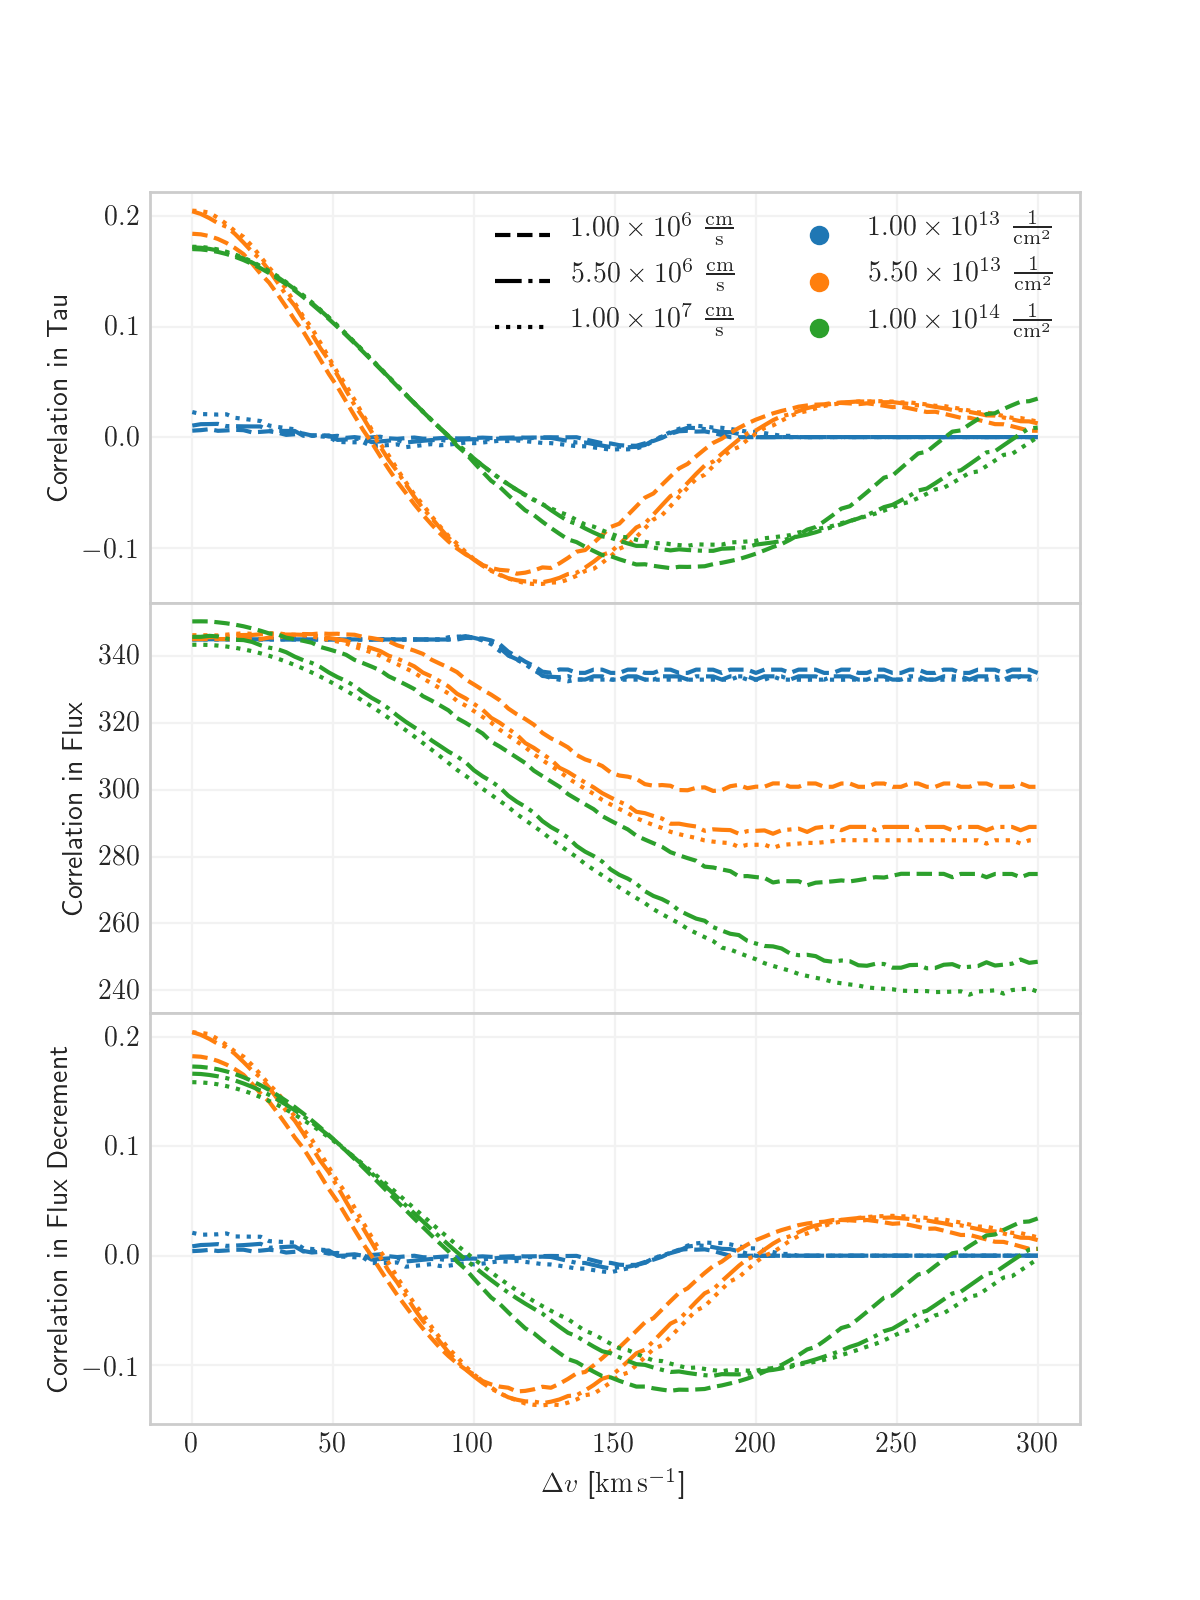

In [8]:
from spectacle.analysis.metrics import CrossCorrelate
res = generate(lambda x1, x2, y1, y2: CrossCorrelate()(y1, y2))
plot_corr(res)

<IPython.core.display.Javascript object>


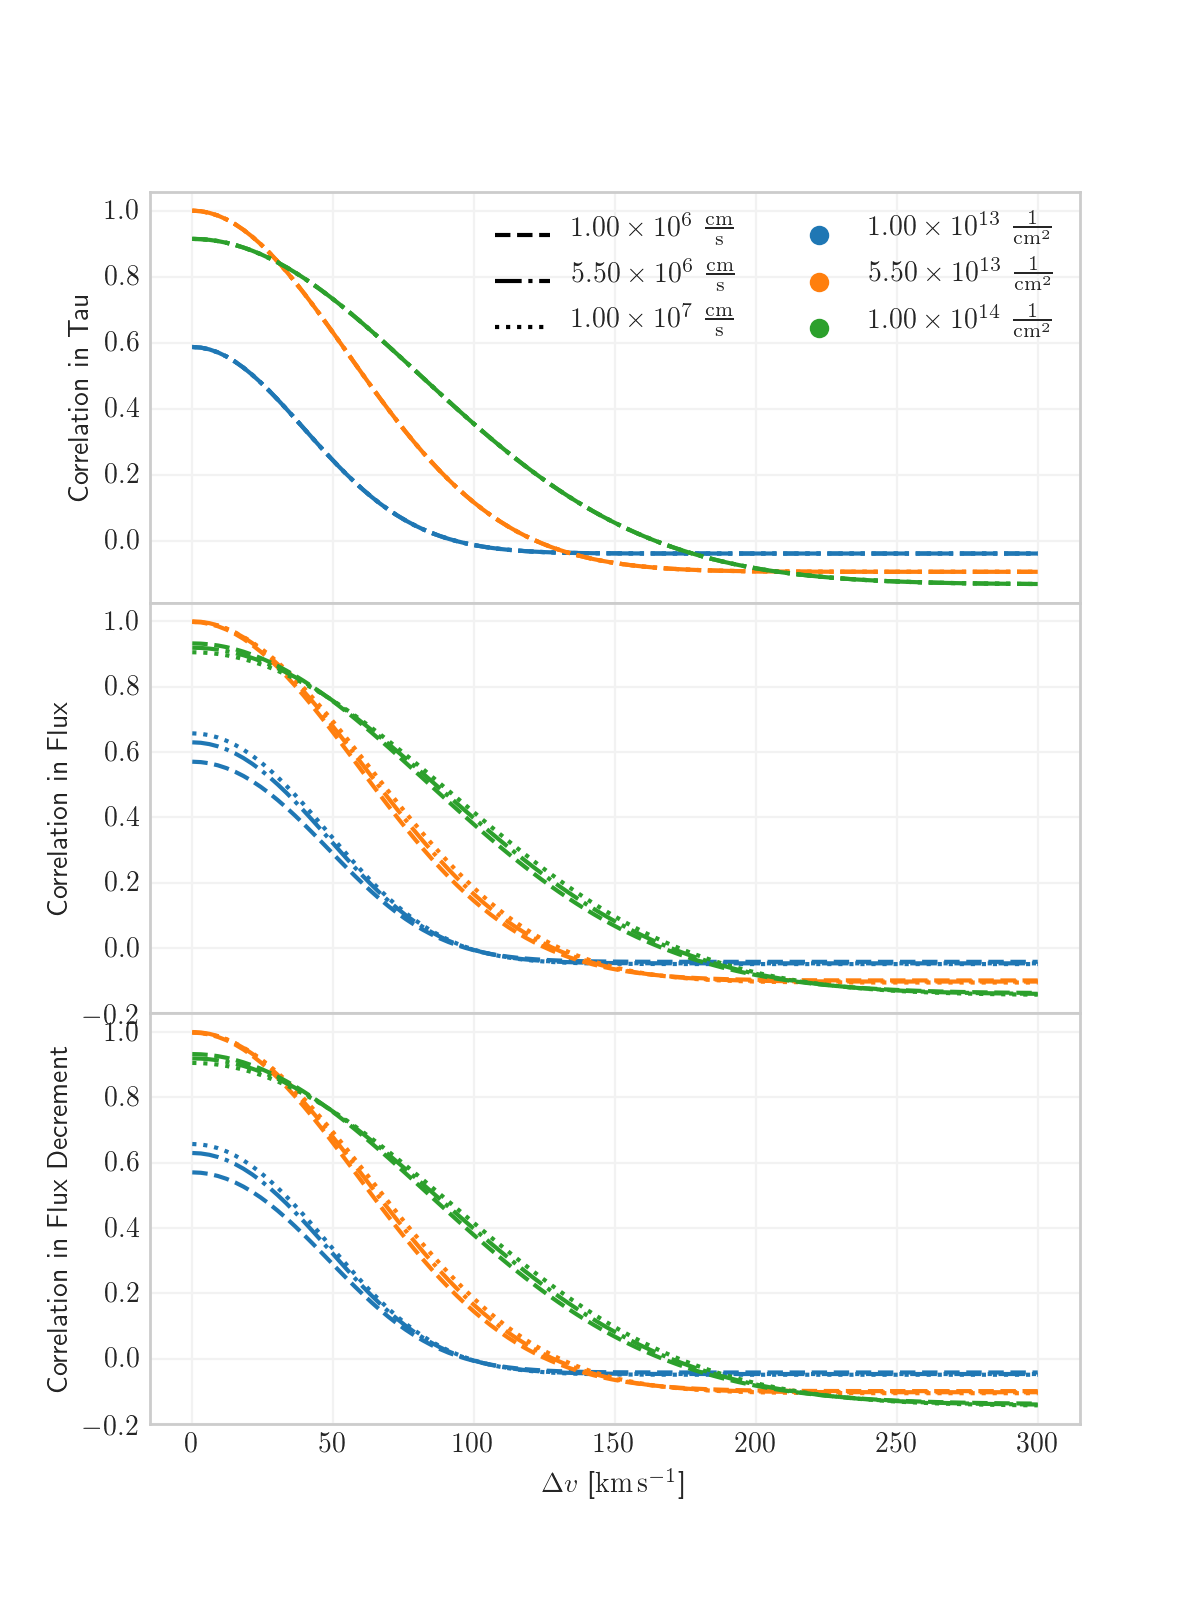

In [9]:
from spectacle.analysis.metrics import CorrMatrixCoeff
res = generate(lambda x1, x2, y1, y2: CorrMatrixCoeff()(y1, y2))
plot_corr(res)

<IPython.core.display.Javascript object>


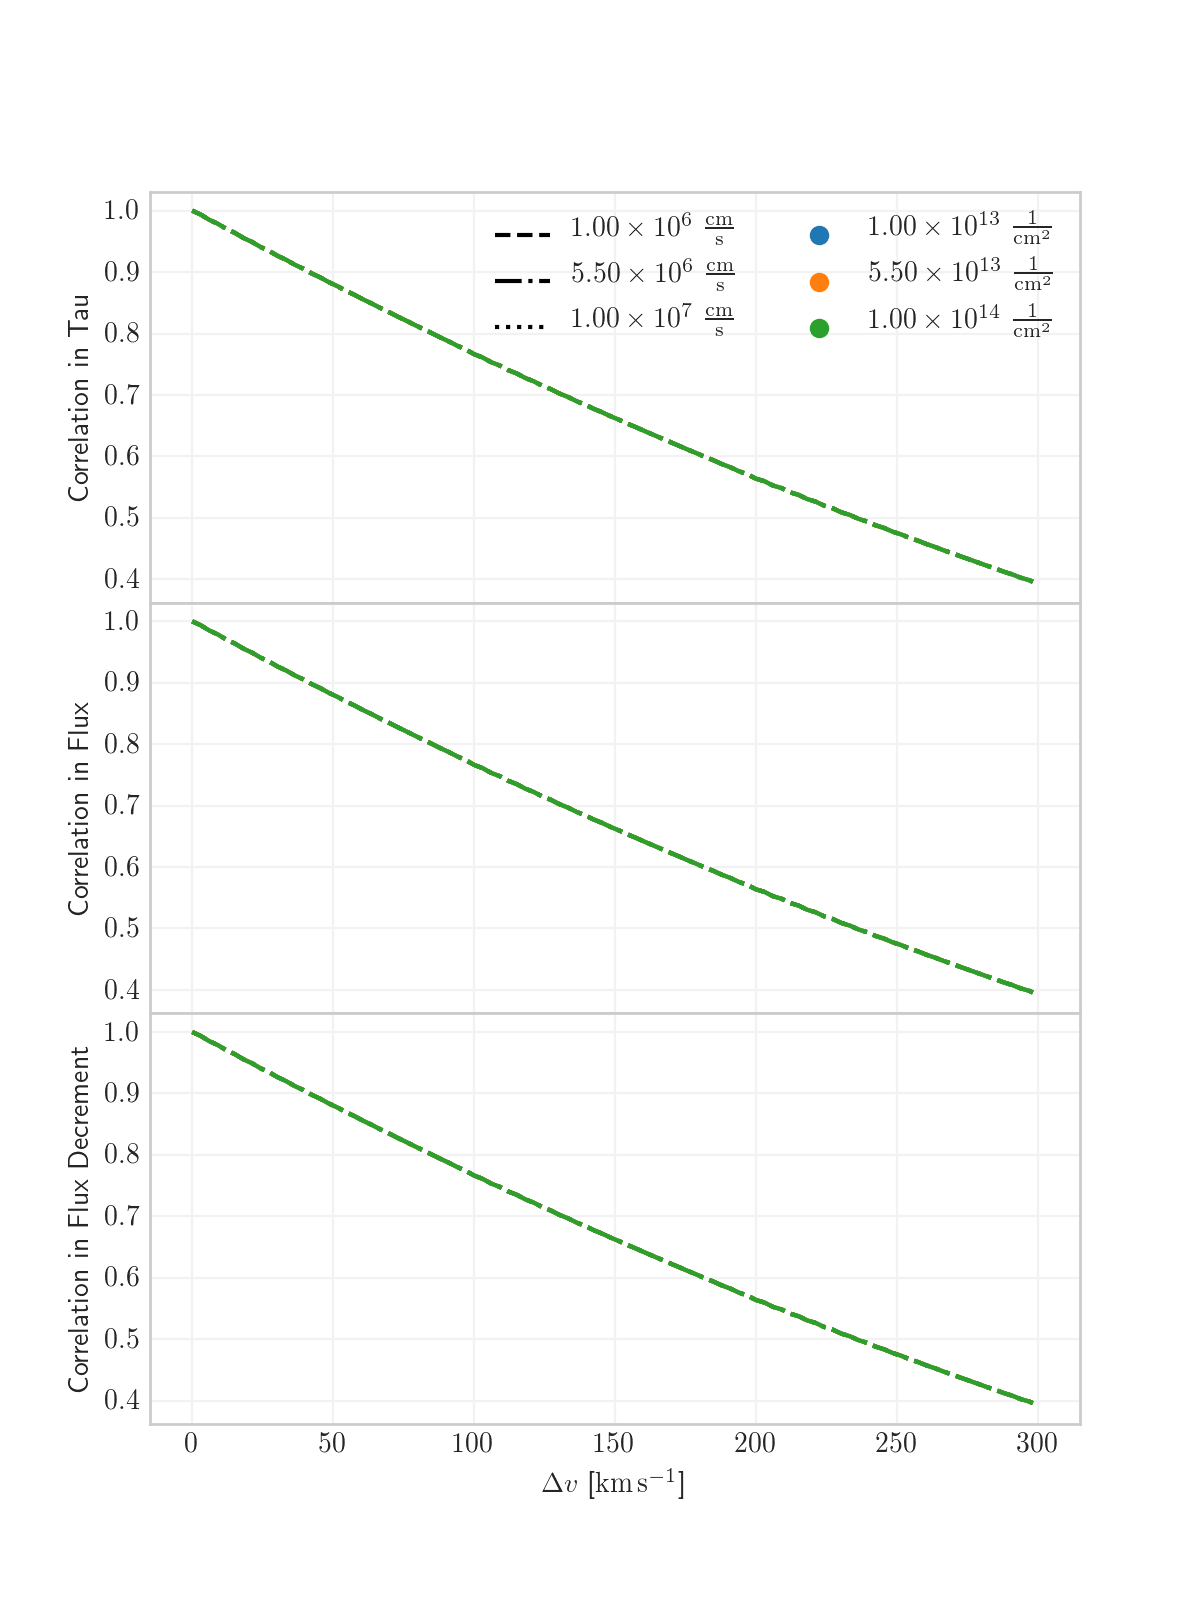

In [10]:
from spectacle.analysis.metrics import KendallsTau
res = generate(lambda x1, x2, y1, y2: KendallsTau()(y1, y2))
plot_corr(res)

<IPython.core.display.Javascript object>


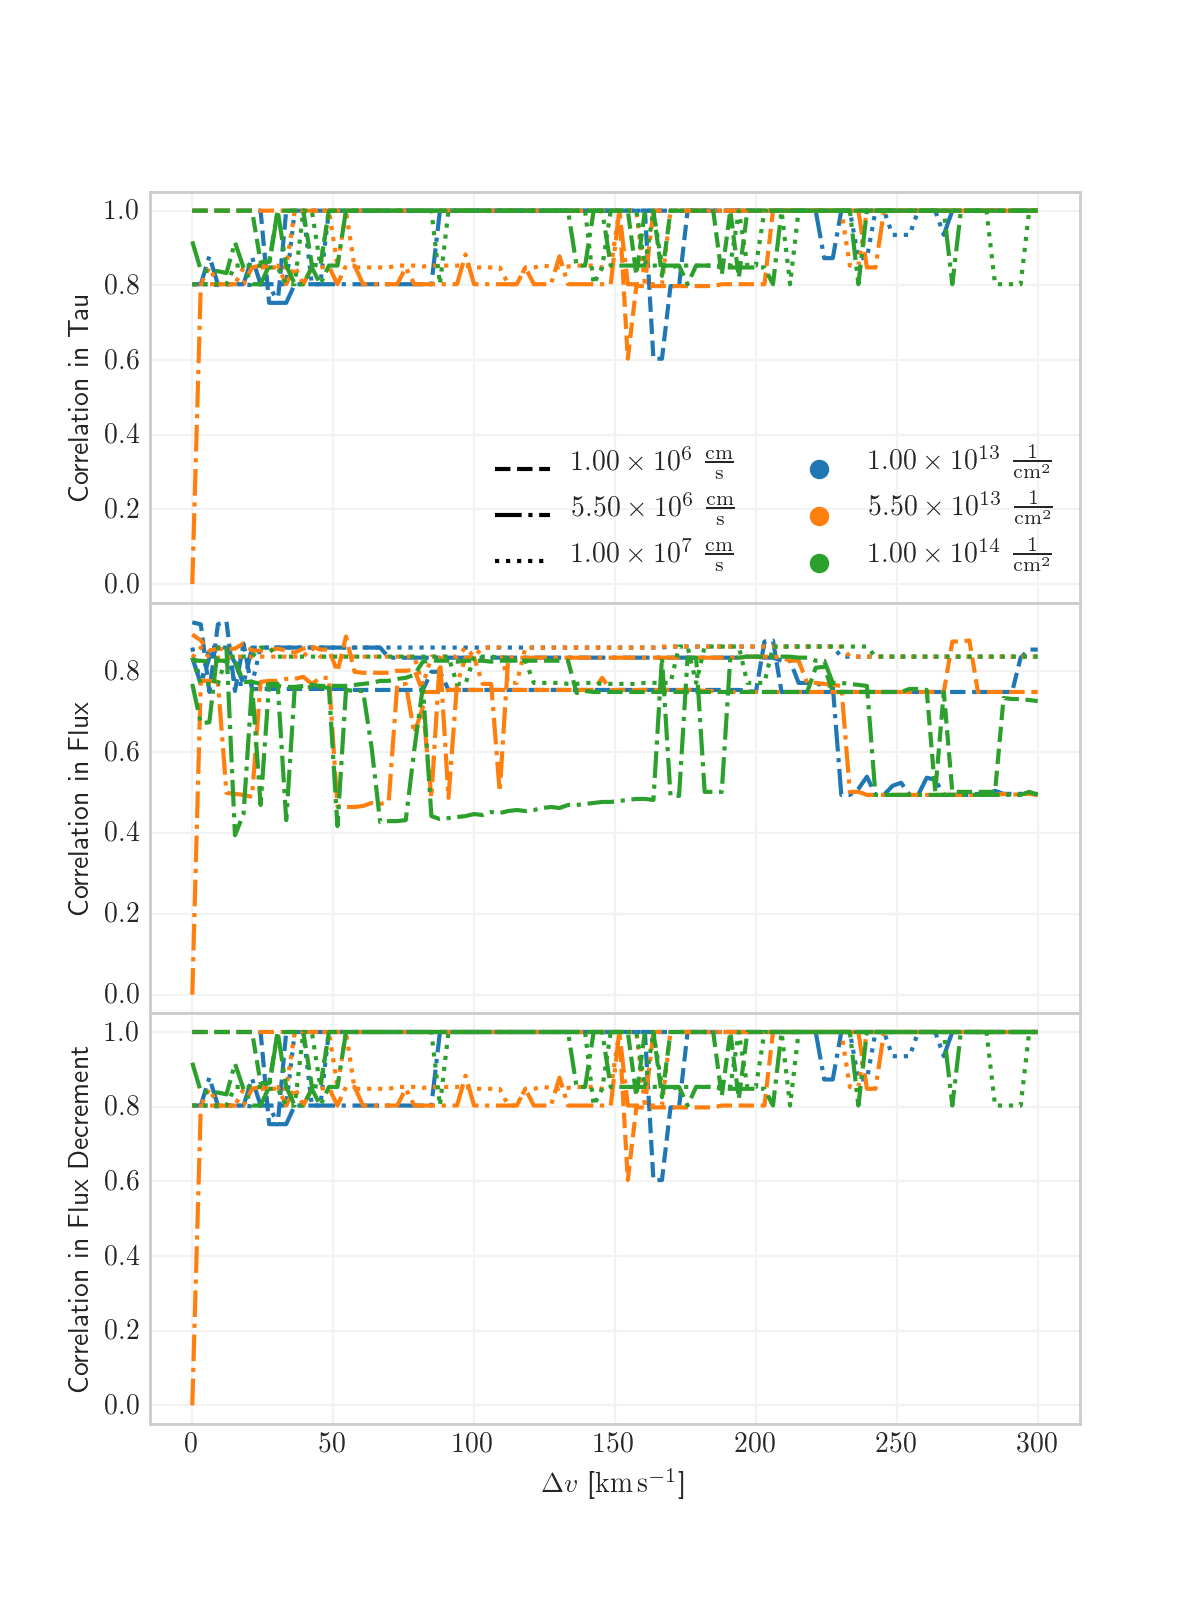

In [11]:
from spectacle.analysis.metrics import KolmogorovSmirnov
res = generate(lambda x1, x2, y1, y2: KolmogorovSmirnov()(y1, y2))
plot_corr(res)

/Users/nearl/anaconda3/envs/spectacle_env/lib/python3.6/site-packages/scipy/stats/morestats.py:1694: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


<IPython.core.display.Javascript object>


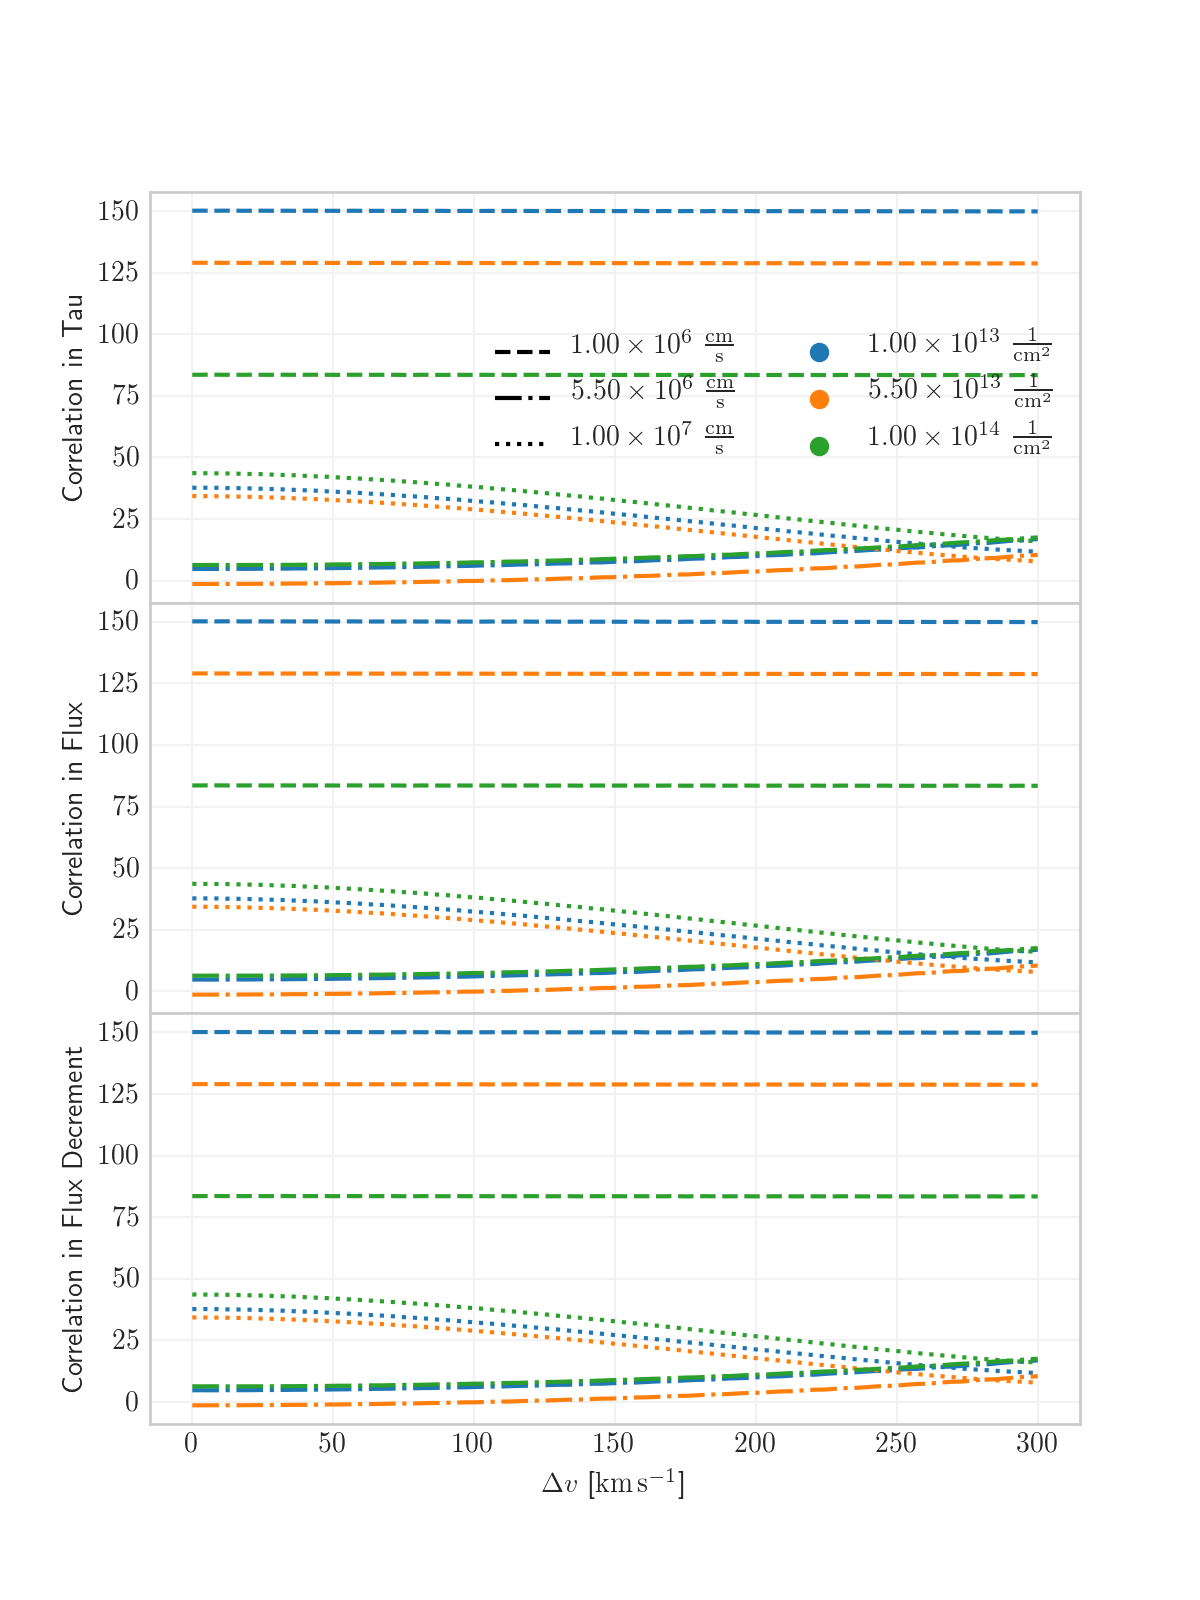

In [12]:
from spectacle.analysis.metrics import AndersonDarling
res = generate(lambda x1, x2, y1, y2: AndersonDarling()(y1, y2))
plot_corr(res)

<IPython.core.display.Javascript object>


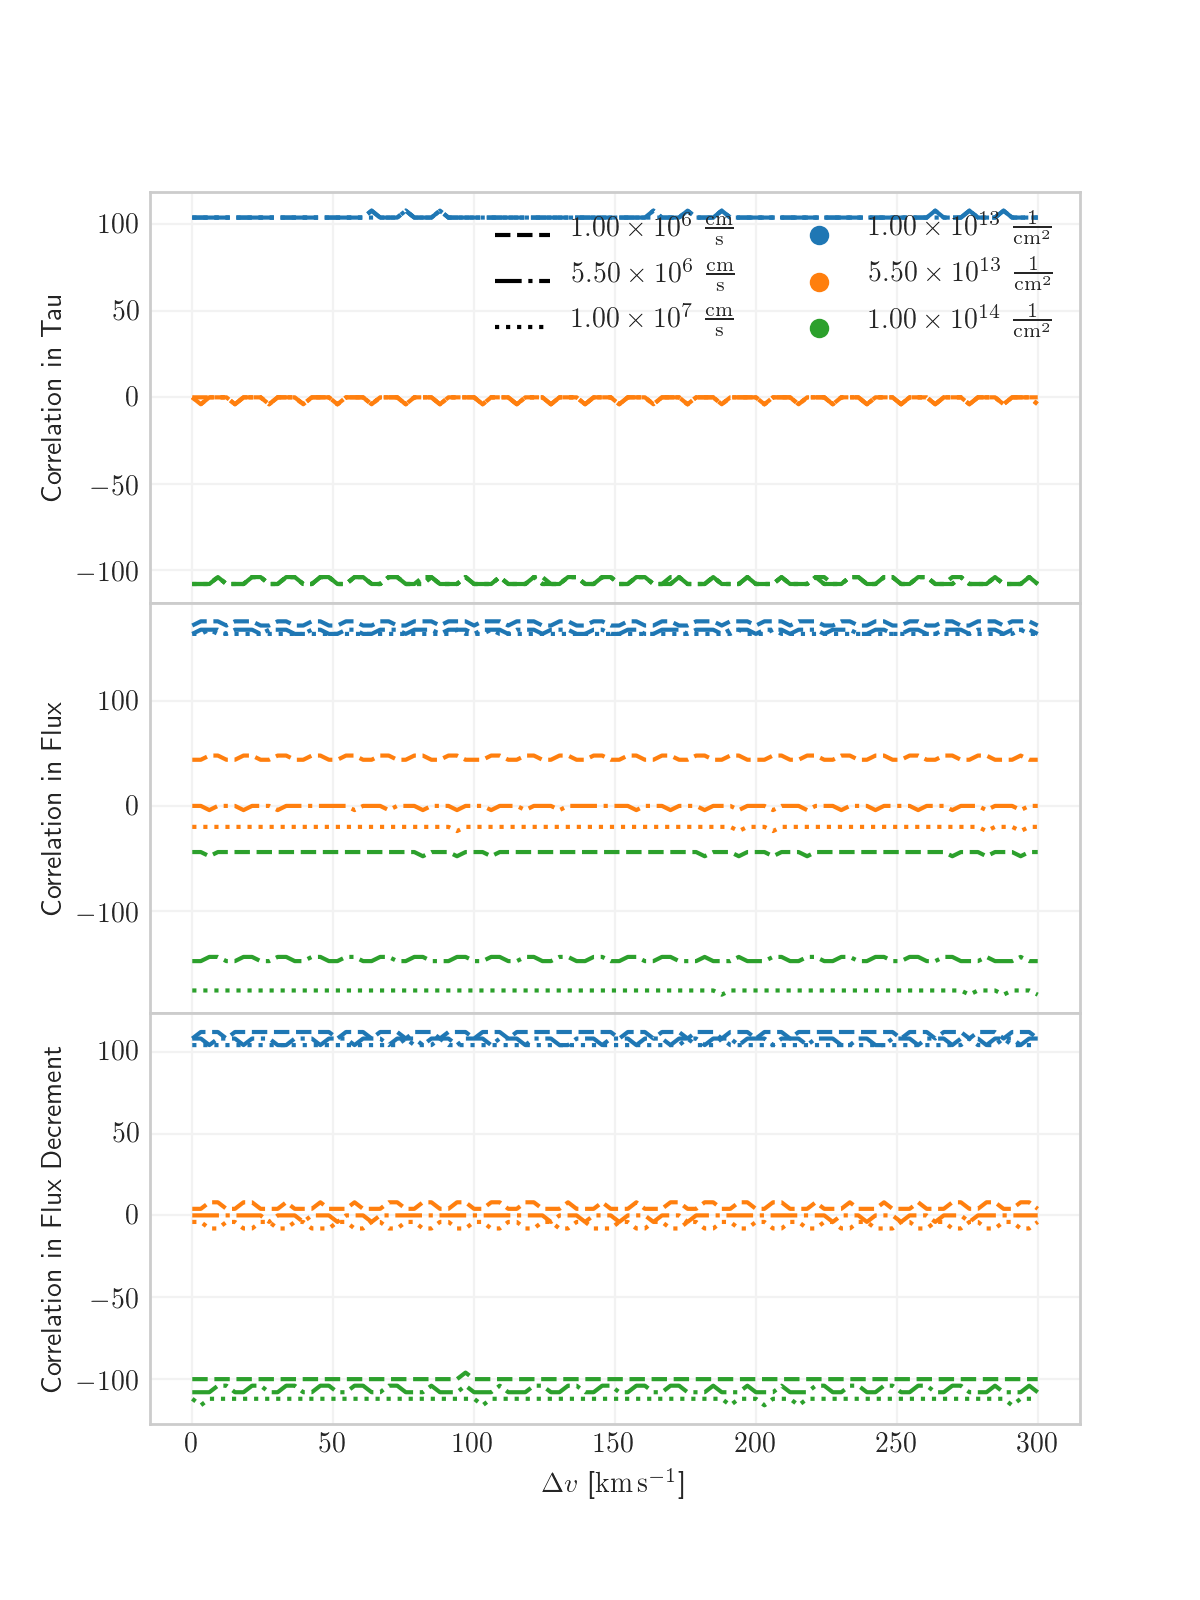

In [13]:
from spectacle.analysis.statistics import delta_v_90

res = generate(lambda x1, x2, y1, y2:
               (delta_v_90(x1, y1)[1].value - delta_v_90(x1, y1)[0].value) -
               (delta_v_90(x2, y2)[1].value - delta_v_90(x2, y2)[0].value))

plot_corr(res)

<IPython.core.display.Javascript object>


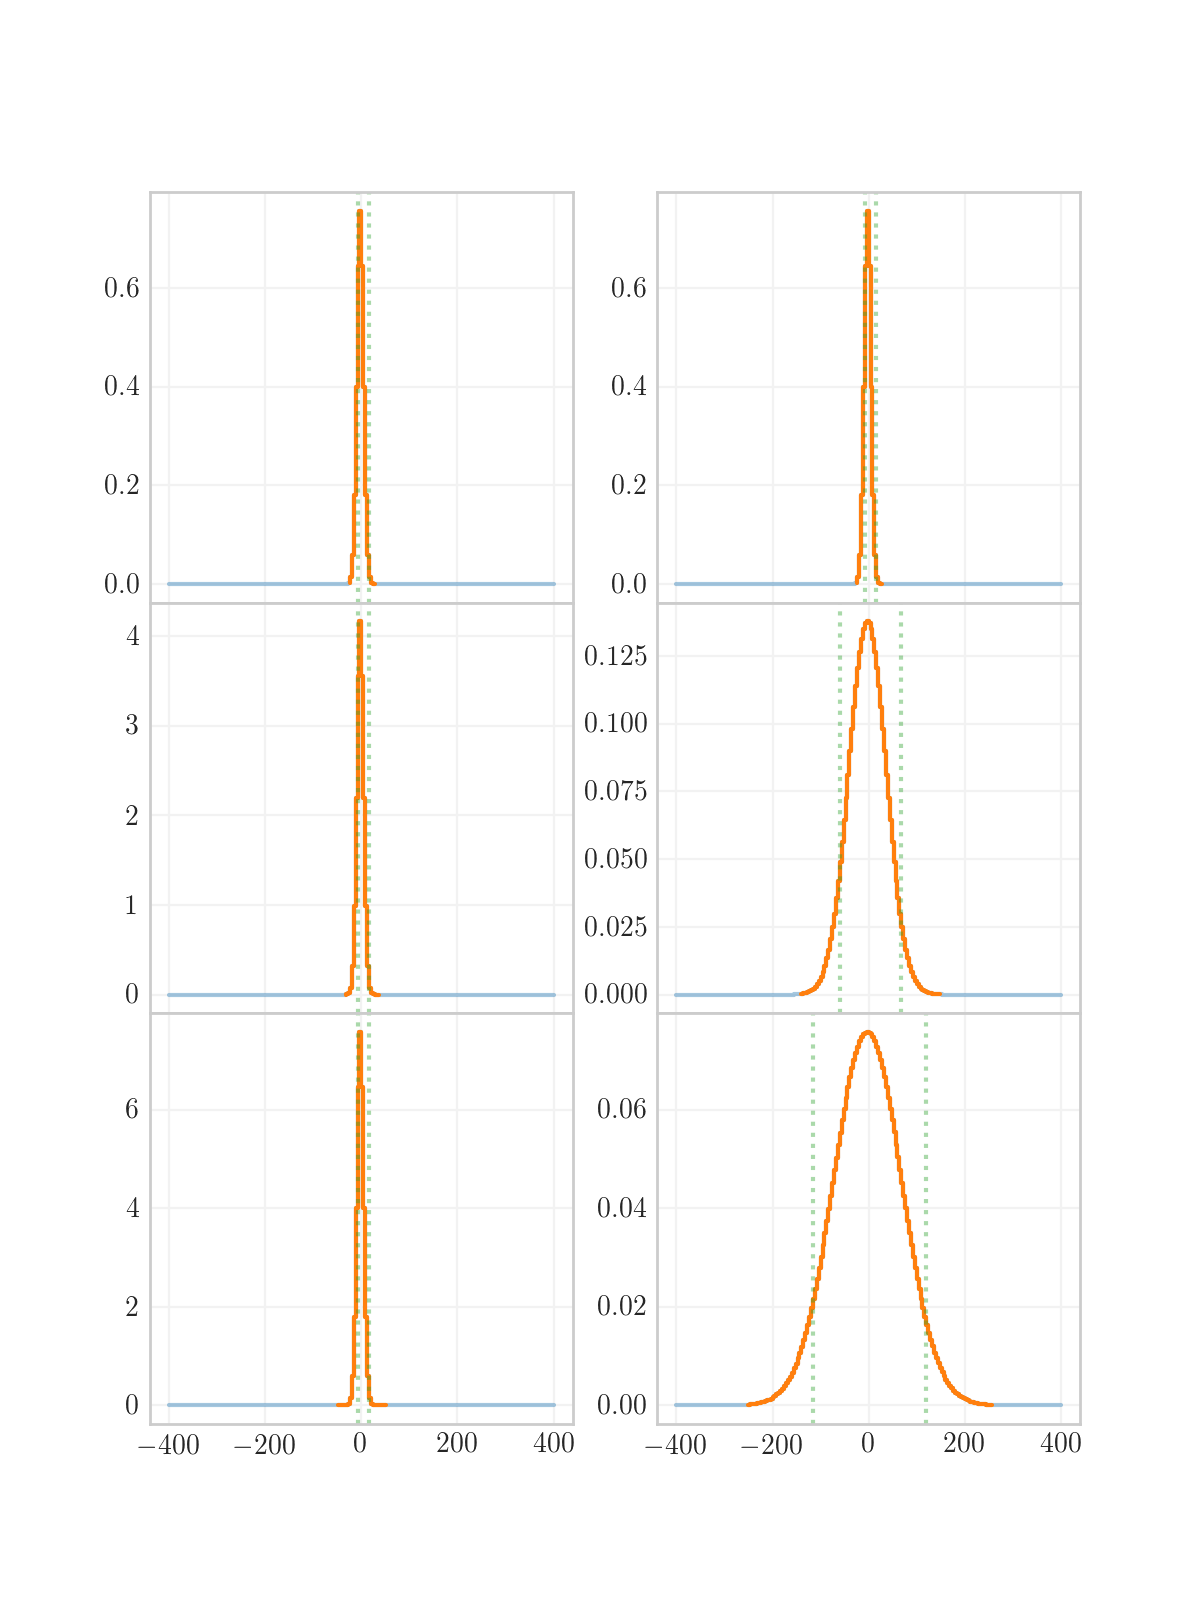

In [14]:
from spectacle.analysis.statistics import delta_v_90


velocity = np.linspace(-400, 400, 201) * u.Unit('km/s')

f, ((ax1, ax4), (ax2, ax5), (ax3, ax6)) = plt.subplots(3, 2, sharex=True)
f.subplots_adjust(hspace=0)

def get_spec(v_dop, col_dens, masked=True):
    line1 = dict(lambda_0=1.21567010E+03 * u.Angstrom,
                 v_doppler=v_dop,
                 column_density=col_dens)

    spectrum1 = Spectrum1D(center=line1['lambda_0']).add_line(**line1)

    if masked:
        x1_t, y1_t = Masker(abs_tol=1e-4)(velocity, spectrum1.tau(velocity))
    else:
        x1_t, y1_t = velocity, spectrum1.tau(velocity)

    return x1_t, y1_t


def plot_dv90(x, y, ax, with_lines=True, *args, **kwargs):
    dv = delta_v_90(x, y)

    ax.step(x, y, *args, **kwargs)
    
    if with_lines:
        ax.axvline(dv[0].value, linestyle=':', color=sns.color_palette()[2], alpha=0.4)
        ax.axvline(dv[1].value, linestyle=':', color=sns.color_palette()[2], alpha=0.4)

# plot_dv90(x1_f, y1_f, ax1)
# plot_dv90(x2_f, y2_f, ax2)

plot_dv90(*get_spec(v_doppler_range[0], column_density_range[0], False), 
          ax1, alpha=0.4, with_lines=False, 
          label="$\\num{{ {0.value:0.02e} }}$ {0.unit:latex}")
plot_dv90(*get_spec(v_doppler_range[0], column_density_range[1], False), 
          ax2, alpha=0.4, with_lines=False, 
          label="$\\num{{ {0.value:0.02e} }}$ {0.unit:latex}")
plot_dv90(*get_spec(v_doppler_range[0], column_density_range[2], False), 
          ax3, alpha=0.4, with_lines=False, 
          label="$\\num{{ {0.value:0.02e} }}$ {0.unit:latex}")

plot_dv90(*get_spec(v_doppler_range[0], column_density_range[0]), ax1)
plot_dv90(*get_spec(v_doppler_range[0], column_density_range[1]), ax2)
plot_dv90(*get_spec(v_doppler_range[0], column_density_range[2]), ax3)

plot_dv90(*get_spec(v_doppler_range[0], column_density_range[0], False), 
          ax4, alpha=0.4, with_lines=False, 
          label="$\\num{{ {0.value:0.02e} }}$ {0.unit:latex}")
plot_dv90(*get_spec(v_doppler_range[1], column_density_range[0], False), 
          ax5, alpha=0.4, with_lines=False, 
          label="$\\num{{ {0.value:0.02e} }}$ {0.unit:latex}")
plot_dv90(*get_spec(v_doppler_range[2], column_density_range[0], False), 
          ax6, alpha=0.4, with_lines=False, 
          label="$\\num{{ {0.value:0.02e} }}$ {0.unit:latex}")

plot_dv90(*get_spec(v_doppler_range[0], column_density_range[0]), ax4)
plot_dv90(*get_spec(v_doppler_range[1], column_density_range[0]), ax5)
plot_dv90(*get_spec(v_doppler_range[2], column_density_range[0]), ax6)

# plot_dv90(x1_d, y1_d, ax5)
# plot_dv90(x2_d, y2_d, ax6)